In [1]:
######################
## General packages ##
######################

import os
import sys
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [2]:
#################################
## Load visualization packages ##
#################################

from covid19model.visualization.output import color_timeframes
from covid19model.visualization.output import color_timeframes
from covid19model.visualization.output import _apply_tick_locator 
from covid19model.models.utils import output_to_visuals, add_negative_binomial

## National model

In [3]:
##################################
## Import the necessary modules ##
##################################

from covid19model.data import sciensano
from covid19model.models.utils import initialize_COVID19_SEIQRD_hybrid_vacc

################################
## Define simulation settings ##
################################

# Number of simulations for structural uncertainty
N = 90
# Number of negative binomial draws on each simulation
K = 100
# Number of cores to use for the simulations
processes = 18
# End of simulation
end_sim = '2021-09-01'
# Confidence level used to visualise model fit
conf_int = 0.05
# Spatial aggregation
agg = 'national'
# Number of age groups
age_stratification_size = 10
# BASE dictionary name
filename = 'national_REF_sto_SAMPLES_2022-10-20.json'

##############################
## Define results locations ##
##############################

# Path where figures and results should be stored
fig_path = '../../results/calibrations/COVID19_SEIQRD/'+agg+'/others/WAVE1/'
# Path where MCMC samples should be saved
samples_path = '../../data/interim/model_parameters/COVID19_SEIQRD/calibrations/'+agg+'/'
# Verify that the paths exist and if not, generate them
for directory in [fig_path, samples_path]:
    if not os.path.exists(directory):
        os.makedirs(directory)

#############################
## Load samples dictionary ##
#############################

from covid19model.models.utils import load_samples_dict
samples_dict_national = load_samples_dict(samples_path+str(filename), age_stratification_size=age_stratification_size)
dispersion = float(samples_dict_national['dispersion'])
# Start of calibration warmup and beta
start_calibration = samples_dict_national['start_calibration']
# Last datapoint used to calibrate warmup and beta
end_calibration = samples_dict_national['end_calibration']

##################################################
## Load data not needed to initialize the model ##
##################################################

# Hospitalization data
public_spatial_hosp_df = sciensano.get_sciensano_COVID19_data(update=False)[0]['H_in']
# Serodata
df_sero_herzog, df_sero_sciensano = sciensano.get_serological_data()

##########################
## Initialize the model ##
##########################

model_national, base_samples_dict, initN = initialize_COVID19_SEIQRD_hybrid_vacc(age_stratification_size=age_stratification_size,
                                                                        update_data=False, start_date=start_calibration,
                                                                        stochastic=True)

#######################
## Sampling function ##
#######################

from covid19model.models.utils import draw_fnc_COVID19_SEIQRD_hybrid_vacc as draw_fnc_national

## Spatial model

In [4]:
##################################
## Import the necessary modules ##
##################################

from covid19model.data import sciensano
from covid19model.models.utils import initialize_COVID19_SEIQRD_spatial_hybrid_vacc

################################
## Define simulation settings ##
################################

# Number of simulations for structural uncertainty
N = 90
# Number of negative binomial draws on each simulation
K = 100
# Number of cores to use for the simulations
processes = 18
# End of simulation
end_sim = '2021-09-01'
# Confidence level used to visualise model fit
conf_int = 0.05
# Spatial aggregation
agg = 'prov'
# Number of age groups
age_stratification_size = 10
# BASE dictionary name
filename = 'prov_REF_sto_SAMPLES_2022-10-26.json'

##############################
## Define results locations ##
##############################

# Path where figures and results should be stored
fig_path = '../../results/calibrations/COVID19_SEIQRD/'+agg+'/others/WAVE1/'
# Path where MCMC samples should be saved
samples_path = '../../data/interim/model_parameters/COVID19_SEIQRD/calibrations/'+agg+'/'
# Verify that the paths exist and if not, generate them
for directory in [fig_path, samples_path]:
    if not os.path.exists(directory):
        os.makedirs(directory)
        

#############################
## Load samples dictionary ##
#############################

from covid19model.models.utils import load_samples_dict
samples_dict_spatial = load_samples_dict(samples_path+str(filename), age_stratification_size=age_stratification_size)
dispersion = float(samples_dict_spatial['dispersion'])
# Start of calibration warmup and beta
start_calibration = samples_dict_spatial['start_calibration']
# Last datapoint used to calibrate warmup and beta
end_calibration = samples_dict_spatial['end_calibration']

##################################################
## Load data not needed to initialize the model ##
##################################################

# Hospitalization data
public_spatial_hosp_df = sciensano.get_sciensano_COVID19_data(update=False)[0]['H_in']
# Serodata
df_sero_herzog, df_sero_sciensano = sciensano.get_serological_data()

##########################
## Initialize the model ##
##########################

model_spatial, base_samples_dict, initN = initialize_COVID19_SEIQRD_spatial_hybrid_vacc(age_stratification_size=age_stratification_size,
                                                                                agg=agg, update_data=False, start_date=start_calibration,
                                                                                stochastic=True)

#######################
## Sampling function ##
#######################

from covid19model.models.utils import draw_fnc_COVID19_SEIQRD_spatial_hybrid_vacc as draw_fnc_spatial

In [5]:
########################
## Simulate scenarios ##
########################

out_national = []
out_spatial = []
start_relaxations=['2021-03-01','2021-04-01','2021-05-01','2021-06-01']
for start_relaxation in start_relaxations:
    print(f'Currently at relaxation date: {start_relaxation}')
    model_national.parameters['start_relaxation'] = start_relaxation
    out_national.append(model_national.sim(end_sim, start_date=start_calibration, N=N, l=1/2, processes=processes,
                         draw_fcn=draw_fnc_national,samples=samples_dict_national))
    model_spatial.parameters['start_relaxation'] = start_relaxation
    out_spatial.append(model_spatial.sim(end_sim, start_date=start_calibration, N=N, l=1/2, processes=processes,
                         draw_fcn=draw_fnc_spatial,samples=samples_dict_spatial))
    
##############################
## Reduce output dimensions ##
##############################

for i in range(len(start_relaxations)):
    tmp_national = out_national[i]
    for dimension in out_national[i].dims:
        if ((dimension != 'time')&(dimension != 'draws')):
            tmp_national = tmp_national.sum(dim=dimension)
    out_national[i] = tmp_national  
    
    tmp_spatial = out_spatial[i]
    for dimension in out_spatial[i].dims:
        if ((dimension != 'time')&(dimension != 'draws')):
            tmp_spatial = tmp_spatial.sum(dim=dimension)
    out_spatial[i] = tmp_spatial

Currently at relaxation date: 2021-03-01
Currently at relaxation date: 2021-04-01
Currently at relaxation date: 2021-05-01
Currently at relaxation date: 2021-06-01


## Compute contacts

In [9]:
start_visualization = '2020-09-01'
end_visualization = '2021-09-01'

In [10]:
# Import time-dependent parameter functions for resp. P, Nc, alpha, N_vacc, season_factor
from covid19model.models.time_dependant_parameter_fncs import  make_contact_matrix_function
# Import packages containing functions to load in data used in the model and the time-dependent parameter functions
from covid19model.data import mobility, model_parameters
df_google = mobility.get_google_mobility_data(update=False, provincial=True)
Nc_dict, params, samples_dict, initN = model_parameters.get_COVID19_SEIQRD_parameters(agg='prov')
policy_function_scenarios = make_contact_matrix_function(df_google, Nc_dict, G=11).policies_all_spatial_manuscript#.policies_all_spatial
policy_function_normal = make_contact_matrix_function(df_google, Nc_dict, G=11).policies_all_spatial

In [11]:
dates = pd.date_range(start=start_visualization, end=end_visualization)
contacts=[]
for start_relaxation in start_relaxations:
    c=[]
    for date in dates:
        c.append(np.mean(np.sum(policy_function_scenarios(date ,{}, {}, model_national.parameters['l1'], model_national.parameters['l2'],
                                model_national.parameters['eff_schools'], model_national.parameters['eff_work'],
                                model_national.parameters['eff_rest'], model_national.parameters['eff_home'],
                                model_national.parameters['mentality'], start_relaxation),axis=1)))
    contacts.append(pd.Series(index=dates, data=c))
    
c=[]
for date in dates:
    c.append(np.mean(np.sum(policy_function_normal(date ,{}, {}, model_national.parameters['l1'], model_national.parameters['l2'],
                                model_national.parameters['eff_schools'], model_national.parameters['eff_work'],
                                model_national.parameters['eff_rest'], model_national.parameters['eff_home'],
                                model_national.parameters['mentality']),axis=1)))
contacts_normal = pd.Series(index=dates, data=c)

## Visualize results

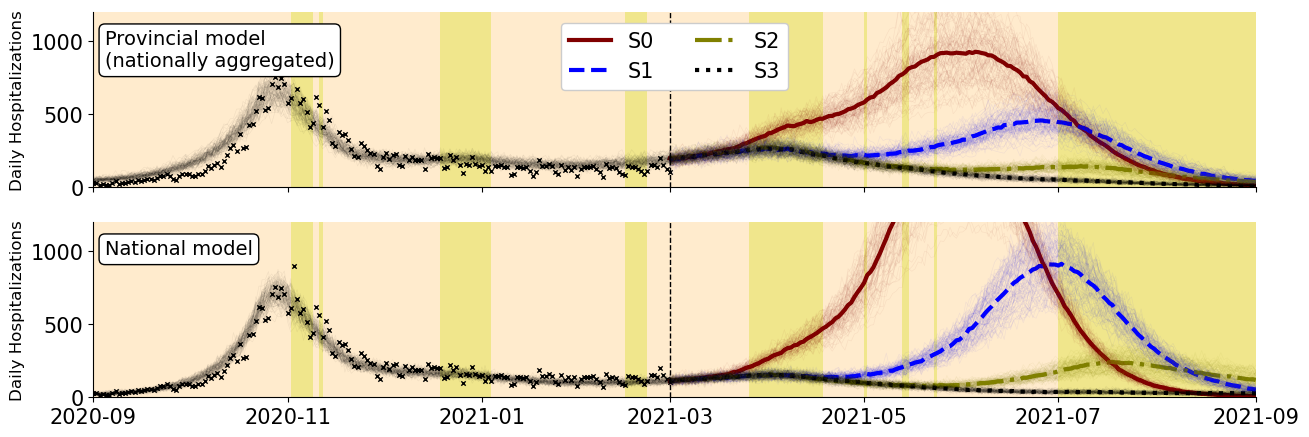

In [16]:
#######################
## Visualize results ##
#######################

start_visualization = '2020-09-01'
end_visualization = '2021-09-01'
start_scenarios = '2021-03-01'

scenario_linestyles=['-','--','-.',':']
legend_text=['S0', 'S1', 'S2', 'S3']
scatter_size = 10
alpha_scatter = 1
# Model prediction properties
linewidth=0.5
alpha_structural=0.05
scenario_colors = ['maroon', 'blue', 'olive', 'black']
# Data
y_data = public_spatial_hosp_df.groupby(by='date').sum()[:start_scenarios]
x_data = y_data.index

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15,5), gridspec_kw={'height_ratios': [1, 1]}, sharex=True)

output = [out_spatial, out_national]
for k,out in enumerate(output):
    
    x_model = out[0].time.values

    #########################
    ## Loop over scenarios ##
    #########################

    for i in range(len(start_relaxations)):
        ax[k].plot(out[i]['H_in'].mean(dim='draws').sel(time=slice(start_scenarios, None))['time'].values,
                    out[i]['H_in'].mean(dim='draws').sel(time=slice(start_scenarios, None)), color=scenario_colors[i],
                    alpha=1, linestyle=scenario_linestyles[i])
        if k == 0:
            ax[k].legend(legend_text, loc=9, ncol=2, framealpha=1)

    for i in range(len(start_relaxations)):
        for j in range(1,N):
            ax[k].plot(out[i]['H_in'].isel(draws=j).sel(time=slice(start_scenarios, None))['time'].values,
                    out[i]['H_in'].isel(draws=j).sel(time=slice(start_scenarios, None)), color=scenario_colors[i],
                    linewidth=linewidth, alpha=alpha_structural)

    ################################################
    ## Plot one model prediction until March 30th ##
    ################################################

    for i in range(N):
        ax[k].plot(out[0]['H_in'].isel(draws=i).sel(time=slice(None, start_scenarios))['time'].values,
                out[0]['H_in'].isel(draws=i).sel(time=slice(None, start_scenarios)), color='black',
                linewidth=linewidth, alpha=alpha_structural)

    ########################
    ## Plot national data ##
    ########################

    ax[k].scatter(x_data, y_data, s=scatter_size, color='k', marker='x', linewidth=1, alpha=alpha_scatter)

    ########################
    ## Plot vertical line ##
    ########################

    ax[k].axvline(x=pd.Timestamp('2021-03-01'), color='k', linestyle='--', linewidth=1)

    ################
    ## Background ##
    ################

    start_background = pd.Timestamp(2020, 1, 1)
    week_color='blanchedalmond'#'white'
    weekend_color='blanchedalmond'#'lightgrey'
    vacation_color='khaki'#weekend_color
    color_timeframes(start_background, end_sim, ax=ax[k], week_color=week_color, weekend_color=weekend_color, vacation_color=vacation_color)

    ###################
    ## Format figure ##
    ###################

    ax[k].set_xlim([pd.Timestamp(start_visualization), pd.Timestamp(end_visualization)])
    ax[k].set_ylim([0, 1200])
    ax[k].grid(False)
    ax[k].set_ylabel('Daily Hospitalizations', fontsize=12)
    
    ##############
    ## Text box ##
    ##############

    titles = ['Provincial model\n(nationally aggregated)', 'National model']   
    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='white', alpha=1)
    # place a text box in upper left in axes coords
    ax[k].text(0.01, 0.90, titles[k], transform=ax[k].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

###################
## Plot contacts ##
###################

#ax[2].plot(contacts_normal[:start_scenarios], color='gray')
#for i in range(len(start_relaxations)):
#    ax[2].plot(contacts[i][start_scenarios:], color=scenario_colors[i], linestyle=scenario_linestyles[i])
#ax[2].set_ylabel('No. contacts', fontsize=12)

plt.savefig(f"four_projected_scenarios_1mar2021.pdf", bbox_inches='tight')

## Contacts only

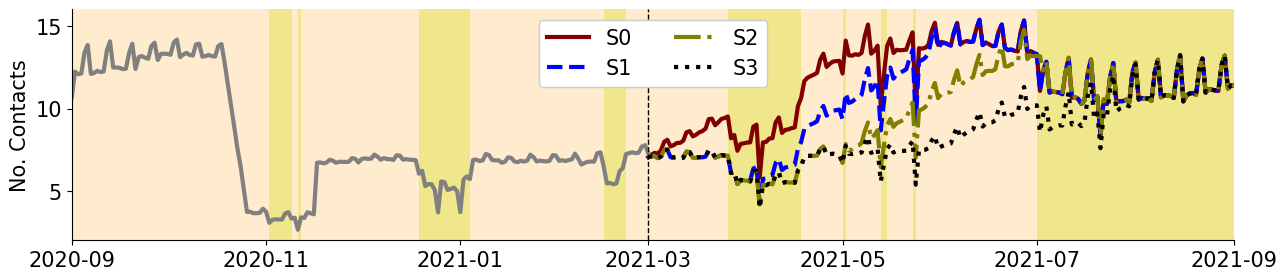

In [15]:
fig, ax = plt.subplots(figsize=(15,3))

###################
## Plot contacts ##
###################


for i in range(len(start_relaxations)):
    ax.plot(contacts[i][start_scenarios:], color=scenario_colors[i], linestyle=scenario_linestyles[i])
ax.legend(legend_text, loc=9, ncol=2, framealpha=1)
ax.plot(contacts_normal[:start_scenarios], color='gray')

########################
## Plot vertical line ##
########################

ax.axvline(x=pd.Timestamp('2021-03-01'), color='k', linestyle='--', linewidth=1)

################
## Background ##
################

start_background = pd.Timestamp(2020, 1, 1)
week_color='blanchedalmond'#'white'
weekend_color='blanchedalmond'#'lightgrey'
vacation_color='khaki'#weekend_color
color_timeframes(start_background, end_sim, ax=ax, week_color=week_color, weekend_color=weekend_color, vacation_color=vacation_color)

###################
## Format figure ##
###################

ax.set_xlim([pd.Timestamp(start_visualization), pd.Timestamp(end_visualization)])
ax.grid(False)
ax.set_ylabel('No. Contacts')

plt.savefig(f"four_projected_Nc_1mar2021.pdf", bbox_inches='tight')

## Time-dependent parameter functions used

Don't forget to switch of delta VOC in draw function.

In [ ]:
def policies_all_manuscript(self, t, states, param, l1, l2, eff_schools, eff_work, eff_rest, eff_home, mentality, start_relaxation):
    # Assumption eff_schools = eff_work
    eff_schools=eff_work

    t = pd.Timestamp(t.date())
    # Convert compliance l to dates
    l1_days = pd.Timedelta(l1, unit='D')
    l2_days = pd.Timedelta(l2, unit='D')

    # Define key dates of first wave
    t1 = pd.Timestamp('2020-03-16') # start of lockdown
    t2 = pd.Timestamp('2020-05-15') # gradual re-opening of schools (assume 50% of nominal scenario)
    t3 = pd.Timestamp('2020-07-01') # start of summer holidays
    t4 = pd.Timestamp('2020-08-03') # Summer lockdown in Antwerp
    t5 = pd.Timestamp('2020-08-24') # End of summer lockdown in Antwerp
    t6 = pd.Timestamp('2020-09-01') # end of summer holidays
    t7 = pd.Timestamp('2020-09-21') # Opening universities

    # Define key dates of winter 2020-2021
    t8 = pd.Timestamp('2020-10-19') # lockdown (1)
    t9 = pd.Timestamp('2020-11-02') # lockdown (2)
    t10 = pd.Timestamp('2020-11-16') # schools re-open
    t11 = pd.Timestamp('2020-12-18') # Christmas holiday starts
    t12 = pd.Timestamp('2021-01-04') # Christmas holiday ends
    t13 = pd.Timestamp('2021-02-15') # Spring break starts
    t14 = pd.Timestamp('2021-02-21') # Spring break ends

    start = pd.Timestamp(start_relaxation)
    t15 = pd.Timestamp('2021-03-26') # Start of Easter holiday
    t16 = pd.Timestamp('2021-04-18') # End of Easter holiday
    t17 = pd.Timestamp('2021-07-01') # Start of Summer holidays

    ################
    ## First wave ##
    ################

    if t <= t1:
        return self.__call__(t, eff_home=1, eff_schools=1, eff_work=1, eff_rest=1, mentality=1, school=1) 
    elif t1 < t <= t1 + l1_days:
        policy_old = self.__call__(t, eff_home=1, eff_schools=1, eff_work=1, eff_rest=1, mentality=1, school=1)
        policy_new = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality, school=0)
        return self.ramp_fun(policy_old, policy_new, t, t1, l1)
    elif t1 + l1_days < t <= t2:
        return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality, school=0)
    elif t2 < t <= t3:
        l = (t3 - t2)/pd.Timedelta(days=1)
        r = (t3 - t2)/(t4 - t2)
        policy_old = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality, school=0)
        policy_new = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality + r*(1-mentality), school=0)
        return self.ramp_fun(policy_old, policy_new, t, t2, l)            
    elif t3 < t <= t4:
        l = (t4 - t3)/pd.Timedelta(days=1)
        r = (t3 - t2)/(t4 - t2)
        policy_old = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality + r*(1-mentality), school=0)
        policy_new = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=1, school=0)
        return self.ramp_fun(policy_old, policy_new, t, t3, l)  
    elif t4 < t <= t5:
        return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality, school=0)                                          
    elif t5 < t <= t6:
        return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=1, school=0)      

    ######################      
    ## Winter 2020-2021 ##
    ######################

    elif t6 < t <= t7:
        return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=1, school=0.7)  
    elif t7 < t <= t8:
        return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=1, school=1)  
    elif t8  < t <= t8 + l2_days:
        policy_old = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=1, school=1)
        policy_new = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=0.65*mentality, school=0)
        return self.ramp_fun(policy_old, policy_new, t, t8, l2)
    elif t8 + l2_days < t <= t9:
        return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=0.65*mentality, school=0)
    elif t9 < t <= t10:
        return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=0.65*mentality, school=0)
    elif t10 < t <= t11:
        return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality, school=1) 
    elif t11 < t <= t12:
        return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality, school=0)
    elif t12 < t <= t13:
        return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality, school=1)
    elif t13 < t <= t14:
        return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality, school=0)    

    if start_relaxation == '2021-03-01':
        if t14 < t <= start:
            return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality, school=1)
        elif start < t <= t15:
            l = (t15 - start)/pd.Timedelta(days=1)
            r = (t15 - start)/pd.Timedelta(days=62)
            policy_old = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality, school=1)
            policy_new = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality + r*(1-mentality), school=1)
            return self.ramp_fun(policy_old, policy_new, t, start, l)  
        elif t15 < t <= t16:
            l = (t16 - t15)/pd.Timedelta(days=1)
            r1 = (t15 - start)/pd.Timedelta(days=62)
            r2 = (t16 - start)/pd.Timedelta(days=62)
            policy_old = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality + r1*(1-mentality), school=0)
            policy_new = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality + r2*(1-mentality), school=0)
            return self.ramp_fun(policy_old, policy_new, t, t15, l)  
        elif t16 < t <= start + pd.Timedelta(days=62):
            l = (start+pd.Timedelta(days=62) - t16)/pd.Timedelta(days=1)
            r = (t16 - start)/pd.Timedelta(days=62)
            policy_old = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality + r*(1-mentality), school=1)
            policy_new = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=1, school=1)
            return self.ramp_fun(policy_old, policy_new, t, t16, l)  
        elif start + pd.Timedelta(days=62) < t <= t17:
            return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=1, school=1)
        else:
            return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=1, school=0)

    elif start_relaxation == '2021-04-01':
        if t14 < t <= t15:
            return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality, school=1)
        elif t15 < t <= start:
            return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality, school=0)
        elif start < t <= t16:
            l = (t16-start)/pd.Timedelta(days=1)
            r = (t16 - start)/pd.Timedelta(days=62)
            policy_old = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality, school=0)
            policy_new = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality + r*(1-mentality), school=0)
            return self.ramp_fun(policy_old, policy_new, t, start, l)
        elif t16 < t <= start + pd.Timedelta(days=62):
            l = (start + pd.Timedelta(days=62)-t16)/pd.Timedelta(days=1)
            r = (t16 - start)/pd.Timedelta(days=62)
            policy_old = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality + r*(1-mentality), school=1)
            policy_new = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=1, school=1)
            return self.ramp_fun(policy_old, policy_new, t, t16, l)
        elif start + pd.Timedelta(days=62) < t <= t17:
            return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=1, school=1)
        else:
            return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=1, school=0)

    elif start_relaxation == '2021-05-01':
        if t14 < t <= t15:
            return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality, school=1)
        elif t15 < t <= t16:
            return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality, school=0)  
        elif t16 < t <= start:
            return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality, school=1)
        elif start < t <= start + pd.Timedelta(days=62):
            l = 62
            policy_old = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality, school=1)
            policy_new = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=1, school=1)
            return self.ramp_fun(policy_old, policy_new, t, start, l)
        else:
            return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=1, school=0)

    elif start_relaxation == '2021-06-01':
        if t14 < t <= t15:
            return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality, school=1)
        elif t15 < t <= t16:
            return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality, school=0)  
        elif t16 < t <= start:
            return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality, school=1)
        elif start < t <= t17:
            l = (t17-start)/pd.Timedelta(days=1)
            r = (t17 - start)/pd.Timedelta(days=62)
            policy_old = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality, school=1)
            policy_new = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality + r*(1-mentality), school=1)
            return self.ramp_fun(policy_old, policy_new, t, start, l)
        elif t17 < t <= start + pd.Timedelta(days=62):
            l = (start + pd.Timedelta(days=62)-t17)/pd.Timedelta(days=1)
            r = (t17 - start)/pd.Timedelta(days=62)
            policy_old = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality + r*(1-mentality), school=0)
            policy_new = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=1, school=0)
            return self.ramp_fun(policy_old, policy_new, t, t17, l)
        else:
            return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=1, school=0)


    def policies_all_spatial_manuscript(self, t, states, param, l1, l2, eff_schools, eff_work, eff_rest, eff_home, mentality, start_relaxation):

    # Assumption eff_schools = eff_work
    eff_schools=eff_work

    t = pd.Timestamp(t.date())
    # Convert compliance l to dates
    l1_days = pd.Timedelta(l1, unit='D')
    l2_days = pd.Timedelta(l2, unit='D')

    # Define key dates of first wave
    t1 = pd.Timestamp('2020-03-16') # start of lockdown
    t2 = pd.Timestamp('2020-05-15') # gradual re-opening of schools (assume 50% of nominal scenario)
    t3 = pd.Timestamp('2020-07-01') # start of summer holidays
    t4 = pd.Timestamp('2020-08-03') # Summer lockdown in Antwerp
    t5 = pd.Timestamp('2020-08-24') # End of summer lockdown in Antwerp
    t6 = pd.Timestamp('2020-09-01') # end of summer holidays
    t7 = pd.Timestamp('2020-09-21') # Opening universities

    # Define key dates of winter 2020-2021
    t8 = pd.Timestamp('2020-10-19') # lockdown (1)
    t9 = pd.Timestamp('2020-11-02') # lockdown (2)
    t10 = pd.Timestamp('2020-11-16') # schools re-open
    t11 = pd.Timestamp('2020-12-18') # Christmas holiday starts
    t12 = pd.Timestamp('2021-01-04') # Christmas holiday ends
    t13 = pd.Timestamp('2021-02-15') # Spring break starts
    t14 = pd.Timestamp('2021-02-21') # Spring break ends

    start = pd.Timestamp(start_relaxation)
    t15 = pd.Timestamp('2021-03-26') # Start of Easter holiday
    t16 = pd.Timestamp('2021-04-18') # End of Easter holiday
    t17 = pd.Timestamp('2021-07-01') # Start of Summer holidays

    if self.G == 11:
        idx_Vlaams_Brabant = [1,]
        idx_Waals_Brabant = [2,]
        idx_F = [0, 1, 4, 5, 8]
        idx_Bxl = [3,]
        idx_W = [2, 6, 7, 9, 10]
        mentality_summer_2020_lockdown = np.array([1*mentality, 0.75*mentality, # F
                                                    1, # W
                                                    1, # Bxl
                                                    0.75*mentality, 1*mentality, # F
                                                    1, 1, # W
                                                    1*mentality, # F
                                                    1*mentality, 1*mentality]) # W

    ################
    ## First wave ##
    ################

    if t <= t1:
        return self.__call__(t, eff_home=1, eff_schools=1, eff_work=1, eff_rest=1, mentality=1, school=1) 
    elif t1 < t <= t1 + l1_days:
        policy_old = self.__call__(t, eff_home=1, eff_schools=1, eff_work=1, eff_rest=1, mentality=1, school=1)
        policy_new = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality, school=0)
        return self.ramp_fun(policy_old, policy_new, t, t1, l1)
    elif t1 + l1_days < t <= t2:
        return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality, school=0)
    elif t2 < t <= t3:
        l = (t3 - t2)/pd.Timedelta(days=1)
        r = (t3 - t2)/(t4 - t2)
        policy_old = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality, school=0)
        policy_new = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality + r*(1-mentality), school=0)
        return self.ramp_fun(policy_old, policy_new, t, t2, l)            
    elif t3 < t <= t4:
        l = (t4 - t3)/pd.Timedelta(days=1)
        r = (t3 - t2)/(t4 - t2)
        policy_old = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality + r*(1-mentality), school=0)
        policy_new = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=1, school=0)
        return self.ramp_fun(policy_old, policy_new, t, t3, l)  
    elif t4 < t <= t5:
        return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=tuple(mentality_summer_2020_lockdown), school=0)                                          
    elif t5 < t <= t6:
        return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=1, school=0)      

    ######################      
    ## Winter 2020-2021 ##
    ######################

    elif t6 < t <= t7:
        return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=1, school=0.7)  
    elif t7 < t <= t8:
        return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=1, school=1)  
    elif t8  < t <= t8 + l2_days:
        policy_old = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=1, school=1)
        policy_new = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=0.65*mentality, school=0)
        return self.ramp_fun(policy_old, policy_new, t, t8, l2)
    elif t8 + l2_days < t <= t9:
        return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=0.65*mentality, school=0)
    elif t9 < t <= t10:
        return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=0.65*mentality, school=0)
    elif t10 < t <= t11:
        return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality, school=1) 
    elif t11 < t <= t12:
        return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality, school=0)
    elif t12 < t <= t13:
        return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality, school=1)
    elif t13 < t <= t14:
        return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality, school=0)    

    if start_relaxation == '2021-03-01':
        if t14 < t <= start:
            return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality, school=1)
        elif start < t <= t15:
            l = (t15 - start)/pd.Timedelta(days=1)
            r = (t15 - start)/pd.Timedelta(days=62)
            policy_old = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality, school=1)
            policy_new = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality + r*(1-mentality), school=1)
            return self.ramp_fun(policy_old, policy_new, t, start, l)  
        elif t15 < t <= t16:
            l = (t16 - t15)/pd.Timedelta(days=1)
            r1 = (t15 - start)/pd.Timedelta(days=62)
            r2 = (t16 - start)/pd.Timedelta(days=62)
            policy_old = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality + r1*(1-mentality), school=0)
            policy_new = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality + r2*(1-mentality), school=0)
            return self.ramp_fun(policy_old, policy_new, t, t15, l)  
        elif t16 < t <= start + pd.Timedelta(days=62):
            l = (start+pd.Timedelta(days=62) - t16)/pd.Timedelta(days=1)
            r = (t16 - start)/pd.Timedelta(days=62)
            policy_old = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality + r*(1-mentality), school=1)
            policy_new = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=1, school=1)
            return self.ramp_fun(policy_old, policy_new, t, t16, l)  
        elif start + pd.Timedelta(days=62) < t <= t17:
            return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=1, school=1)
        else:
            return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=1, school=0)

    elif start_relaxation == '2021-04-01':
        if t14 < t <= t15:
            return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality, school=1)
        elif t15 < t <= start:
            return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality, school=0)
        elif start < t <= t16:
            l = (t16-start)/pd.Timedelta(days=1)
            r = (t16 - start)/pd.Timedelta(days=62)
            policy_old = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality, school=0)
            policy_new = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality + r*(1-mentality), school=0)
            return self.ramp_fun(policy_old, policy_new, t, start, l)
        elif t16 < t <= start + pd.Timedelta(days=62):
            l = (start + pd.Timedelta(days=62)-t16)/pd.Timedelta(days=1)
            r = (t16 - start)/pd.Timedelta(days=62)
            policy_old = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality + r*(1-mentality), school=1)
            policy_new = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=1, school=1)
            return self.ramp_fun(policy_old, policy_new, t, t16, l)
        elif start + pd.Timedelta(days=62) < t <= t17:
            return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=1, school=1)
        else:
            return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=1, school=0)

    elif start_relaxation == '2021-05-01':
        if t14 < t <= t15:
            return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality, school=1)
        elif t15 < t <= t16:
            return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality, school=0)  
        elif t16 < t <= start:
            return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality, school=1)
        elif start < t <= start + pd.Timedelta(days=62):
            l = 62
            policy_old = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality, school=1)
            policy_new = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=1, school=1)
            return self.ramp_fun(policy_old, policy_new, t, start, l)
        else:
            return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=1, school=0)

    elif start_relaxation == '2021-06-01':
        if t14 < t <= t15:
            return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality, school=1)
        elif t15 < t <= t16:
            return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality, school=0)  
        elif t16 < t <= start:
            return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality, school=1)
        elif start < t <= t17:
            l = (t17-start)/pd.Timedelta(days=1)
            r = (t17 - start)/pd.Timedelta(days=62)
            policy_old = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality, school=1)
            policy_new = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality + r*(1-mentality), school=1)
            return self.ramp_fun(policy_old, policy_new, t, start, l)
        elif t17 < t <= start + pd.Timedelta(days=62):
            l = (start + pd.Timedelta(days=62)-t17)/pd.Timedelta(days=1)
            r = (t17 - start)/pd.Timedelta(days=62)
            policy_old = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=mentality + r*(1-mentality), school=0)
            policy_new = self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=1, school=0)
            return self.ramp_fun(policy_old, policy_new, t, t17, l)
        else:
            return self.__call__(t, eff_home, eff_schools, eff_work, eff_rest, mentality=1, school=0)


    def policies_all_work_only_manuscript(self, t, states, param, l1, l2, eff_schools, eff_work, eff_rest, eff_home, mentality, start_relaxation):

        t = pd.Timestamp(t.date())
        # Convert compliance l to dates
        l1_days = pd.Timedelta(l1, unit='D')
        l2_days = pd.Timedelta(l2, unit='D')
        if self.G == 11:
            idx_Vlaams_Brabant = [1,]
            idx_Waals_Brabant = [2,]
            idx_F = [0, 1, 4, 5, 8]
            idx_Bxl = [3,]
            idx_W = [2, 6, 7, 9, 10]
            mentality_summer_2020_lockdown = np.array([1*mentality, 0.75*mentality, # F
                                                    1, # W
                                                    1, # Bxl
                                                    0.75*mentality, 1*mentality, # F
                                                    1, 1, # W
                                                    1*mentality, # F
                                                    1*mentality, 1*mentality]) # W

        ################
        ## First wave ##
        ################

        # Define key dates 
        t1 = pd.Timestamp('2020-03-16') # start of lockdown
        t2 = pd.Timestamp('2020-05-15') # start of relaxation
        t3 = pd.Timestamp('2020-08-03') # Summer lockdown in Antwerp
        t4 = pd.Timestamp('2020-08-24') # End of summer lockdown in Antwerp
        t5 = pd.Timestamp('2020-10-19') # start of lockdown
        t6 = pd.Timestamp('2020-11-16') # schools re-open
        start = pd.Timestamp(start_relaxation)

        # Define number of contacts
        if t <= t1:
            return self.__call__(t, eff_home=0, eff_schools=0, eff_work=1, eff_rest=0, mentality=1, school=0) 
        elif t1 < t <= t1 + l1_days:
            policy_old = self.__call__(t, eff_home=0, eff_schools=0, eff_work=1, eff_rest=0, mentality=1, school=0) 
            policy_new = self.__call__(t, eff_home=0, eff_schools=0, eff_work=eff_work, eff_rest=0, mentality=mentality, school=0) 
            return self.ramp_fun(policy_old, policy_new, t, t1, l1)
        elif t1 + l1_days < t <= t2:
            return self.__call__(t, eff_home=0, eff_schools=0, eff_work=eff_work, eff_rest=0, mentality=mentality, school=0) 
        elif t2 < t <= t3:
            l = (t3 - t2)/pd.Timedelta(days=1)
            policy_old = self.__call__(t, eff_home=0, eff_schools=0, eff_work=eff_work, eff_rest=0, mentality=mentality, school=0) 
            policy_new = self.__call__(t, eff_home=0, eff_schools=0, eff_work=eff_work, eff_rest=0, mentality=1, school=0) 
            return self.ramp_fun(policy_old, policy_new, t, t2, l)
        elif t3 < t <= t4:
            return self.__call__(t, eff_home=0, eff_schools=0, eff_work=eff_work, eff_rest=0, mentality=tuple(mentality_summer_2020_lockdown), school=0)
        elif t4 < t <= t5:
            return self.__call__(t, eff_home=0, eff_schools=0, eff_work=eff_work, eff_rest=0, mentality=1, school=0)       

        ######################
        ## Winter 2020-2021 ##
        ######################

        elif t5  < t <= t5 + l2_days:
            policy_old = self.__call__(t, eff_home=0, eff_schools=0, eff_work=eff_work, eff_rest=0, mentality=1, school=0)
            policy_new = self.__call__(t, eff_home=0, eff_schools=0, eff_work=eff_work, eff_rest=0, mentality=0.65*mentality, school=0)
            return self.ramp_fun(policy_old, policy_new, t, t5, l2)
        elif t5 + l2_days < t <= t6:
            return self.__call__(t, eff_home=0, eff_schools=0, eff_work=eff_work, eff_rest=0, mentality=0.65*mentality, school=0) 
        elif t6 < t <= start:
            return self.__call__(t, eff_home=0, eff_schools=0, eff_work=eff_work, eff_rest=0, mentality=mentality, school=0)
        elif start < t <= start + pd.Timedelta(days=62):
            l = 62
            policy_old = self.__call__(t, eff_home=0, eff_schools=0, eff_work=eff_work, eff_rest=0, mentality=mentality, school=0) 
            policy_new = self.__call__(t, eff_home=0, eff_schools=0, eff_work=eff_work, eff_rest=0, mentality=1, school=0)
            return self.ramp_fun(policy_old, policy_new, t, start, l)
        else:
            return self.__call__(t, eff_home=0, eff_schools=0, eff_work=eff_work, eff_rest=0, mentality=1, school=0)

